# Tutorial: Digital Objects and Synthetic MRI with BART


**Authors**: [Nick Scholand](mailto:scholand@tugraz.at)$^1$, [Martin Heide](mailto:martin.heide@med.uni-goettingen.de)$^2$, [Martin Schilling](mailto:martin.schilling@med.uni-goettingen.de)$^2$

**Institution**: $^1$ Graz University of Technology, $^2$ University Medical Center Goettingen

This tutorial introduces BART's interface for creating digital objects added to the [official BART repository](https://github.com/mrirecon/bart).

This tutorial is based on commit `69b72d8` and focuses on the latest developments published in

> Nick Scholand, Martin Schilling, Martin Heide, Martin Uecker.  
> Digital Reference Objects with BART.  
> In Proc. Intl. Soc. Mag. Reson. Med. 31; 3118 (2023).



### Setup BART on Google Colab

The cell will setup BART on Google Colab. For a detailed explanation, see **How to Run BART on Google Colaboratory** in the [repository 2021](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021). You SHOULD SKIP this part if you want to run this notebook ON BINDER or your local machine with BART already installed.

In [1]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev bc &> /dev/null

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

In [2]:
%%bash

BRANCH=69b72d8

cd bart

# Switch to desired branch of the BART project
git checkout -q $BRANCH

# Define specifications 
COMPILE_SPECS="PARALLEL=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null

In [3]:
import os
import sys

# Define environment variables for BART and OpenMP
os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

#### Check BART version

Let us check the installed BART version.

In [4]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
/content/bart/bart
# BART version: 
v0.8.00-322-g69b72d8


#### Download Required Files

When running this tutorial on Google Colab the required figures and files need to be downloaded.

In [6]:
%%bash

# Download the required supporting material if it is not already there
[ ! -f files.zip ] && wget -q https://github.com/mrirecon/bart-workshop/raw/master/ismrm2023/digital-objects/files.zip

unzip -n files.zip

Archive:  files.zip
   creating: data/
  inflating: data/flower.svg         
   creating: task/
  inflating: task/task.svg           


#### Functions for Visualization

In [7]:
import sys
import os
sys.path.insert(0, os.path.join(os.environ['TOOLBOX_PATH'], 'python'))
import cfl

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def imshow(file,title=None):

	if (None != title):
              if (len(file) != len(file)):
                    raise Exception("Length of titles does not match length of files!")
    
	fig, axes = plt.subplots(1, len(file), figsize=(10*len(file),10))

	for i in range(0, len(file)):

		im = axes[i].imshow(np.abs(cfl.readcfl(file[i]).squeeze()).T, origin="upper", cmap='gray')

		divider = make_axes_locatable(axes[i])
		cax = divider.append_axes("right", size="5%", pad=0.05)
		cbar = plt.colorbar(im, cax=cax)
		cbar.ax.tick_params(labelsize=15)

		axes[i].set_yticklabels([])
		axes[i].set_xticklabels([])
		axes[i].xaxis.set_ticks_position('none')
		axes[i].yaxis.set_ticks_position('none')
		axes[i].set_axis_off()

		if (None != title):
        		axes[i].set_title(title[i], fontsize=25)

def imshow_time(file, ind):

	data = np.abs(cfl.readcfl(file).squeeze())

	fig, axes = plt.subplots(1, len(ind), figsize=(25, 10))

	for i in range(0,len(ind)):

		axes[i].imshow(data[:,:,ind[i]].T, cmap='gray')

		axes[i].set_title('Repetition: '+str(ind[i]), fontsize=25)

		axes[i].set_yticklabels([])
		axes[i].set_xticklabels([])
		axes[i].xaxis.set_ticks_position('none')
		axes[i].yaxis.set_ticks_position('none')
		axes[i].set_axis_off()


                        
from mpl_toolkits.mplot3d import Axes3D

# contourf implementation does not work with older matplotlib versions.
# This tutorial is tested with version 3.7.1
print('matplotlib version: {}'.format(matplotlib.__version__))

def imshow3d(file, title=None):

	fig = plt.figure(figsize=(10*len(file),10))

	for i in range(0, len(file)):

		ax = fig.add_subplot(1, len(file), i+1, projection='3d')

		data = np.abs(cfl.readcfl(file[i]).squeeze())

		center = np.shape(data)[0]//2

		X = np.arange(-center, center, 1)
		Y = np.arange(-center, center, 1)
		Z = np.arange(-center, center, 1)

		# Cut coordinates
		X_top = np.arange(0, center, 1)
		X_bottom = np.arange(-center, 0, 1)

		Y_top = np.arange(0, center, 1)
		Y_bottom = np.arange(-center, 0, 1)

		Z_top = np.arange(0, center, 1)
		Z_bottom = np.arange(-center, 0, 1)

		# yz-plane: 4
		im = ax.contourf(X, data[:,center,0:center], Z_bottom, 100, zdir='y', offset=0, alpha=1, cmap='gray')

		# xz-plane: 3
		im = ax.contourf(data[center,0:center,0:center].T, Y_bottom, Z_bottom, 100, zdir='x', offset=0, alpha=1, cmap='gray')

		# xy-plane: 1 - 4
		im = ax.contourf(X, Y, data[:,:,center].T, 100, zdir='z', offset=0, alpha=1, cmap='gray')

		# xz-plane: 1
		im = ax.contourf(data[center,center:,center:].T, Y_top, Z_top, 100, zdir='x', offset=0, alpha=1, cmap='gray')

		# yz-plane: 1 & 2
		im = ax.contourf(X, data[:,center,center:], Z_top, 100, zdir='y', offset=0, alpha=1, cmap='gray')

		# xz-plane: 2
		im = ax.contourf(data[center,0:center,center:].T, Y_bottom, Z_top, 100, zdir='x', offset=0, alpha=1, cmap='gray')

		ax.set_xlim([-center, center])
		ax.set_ylim([-center, center])
		ax.set_zlim([-center, center])

		ax.set_xlabel("x")
		ax.set_ylabel("y")
		ax.set_zlabel("z")

		if (None != title):
        		ax.set_title(title[i], fontsize=25)

matplotlib version: 3.7.1


## Functionallity of BART's `phantom` Tool

Digital objects in BART are created with the `phantom` tool.
It can be used from the command line. Some basic help is provided when passing the `-h` flag.

In [ ]:
%%bash

# Overview about the functionality of the sim tool.
bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <file>] [-G] [-T] [--NIST] [--SONAR] [--BRAIN] [-N d] [-B] [--FILE <file>] [-x d] [-g d] [-3] [-b] [-r d] [--rotation-angle f] [--rotation-steps d] [--coil ...] <output> 

Image and k-space domain phantoms.

-s nc                     nc sensitivities
-S nc                     Output nc sensitivities
-k                        k-space
-t file                   trajectory
-G                        geometric object phantom
-T                        tubes phantom
--NIST                    NIST phantom (T2 sphere)
--SONAR                   Diagnostic Sonar phantom
--BRAIN                   BRAIN geometry phantom
-N num                    Random tubes phantom and number
-B                        BART logo
--FILE name               Arbitrary geometry based on multicfl file.
-x n                      dimensions in y and z
-g n=1,2,3                select geometry for object phantom
-3                        3D
-b                        basis functions for g

Various geometries are already implemented and many functionallity is provided that can not be covered by this tutorial.

One of the basic features of the `phantom` tool is the option to change the sampling rate: `-x <sampling-rate>`.

To compare its influence the next cell creates two geometries with 128 base resolution (which is the default) and with 512.

In [ ]:
%%bash

# Simulate phantom with default sampling rate 128
bart phantom p

# Change the sampling rate and simulate a new phantom
NEW_BASE_RESOLUTION=512
bart phantom -x $NEW_BASE_RESOLUTION p2

With a small script both phantoms can be visualized.

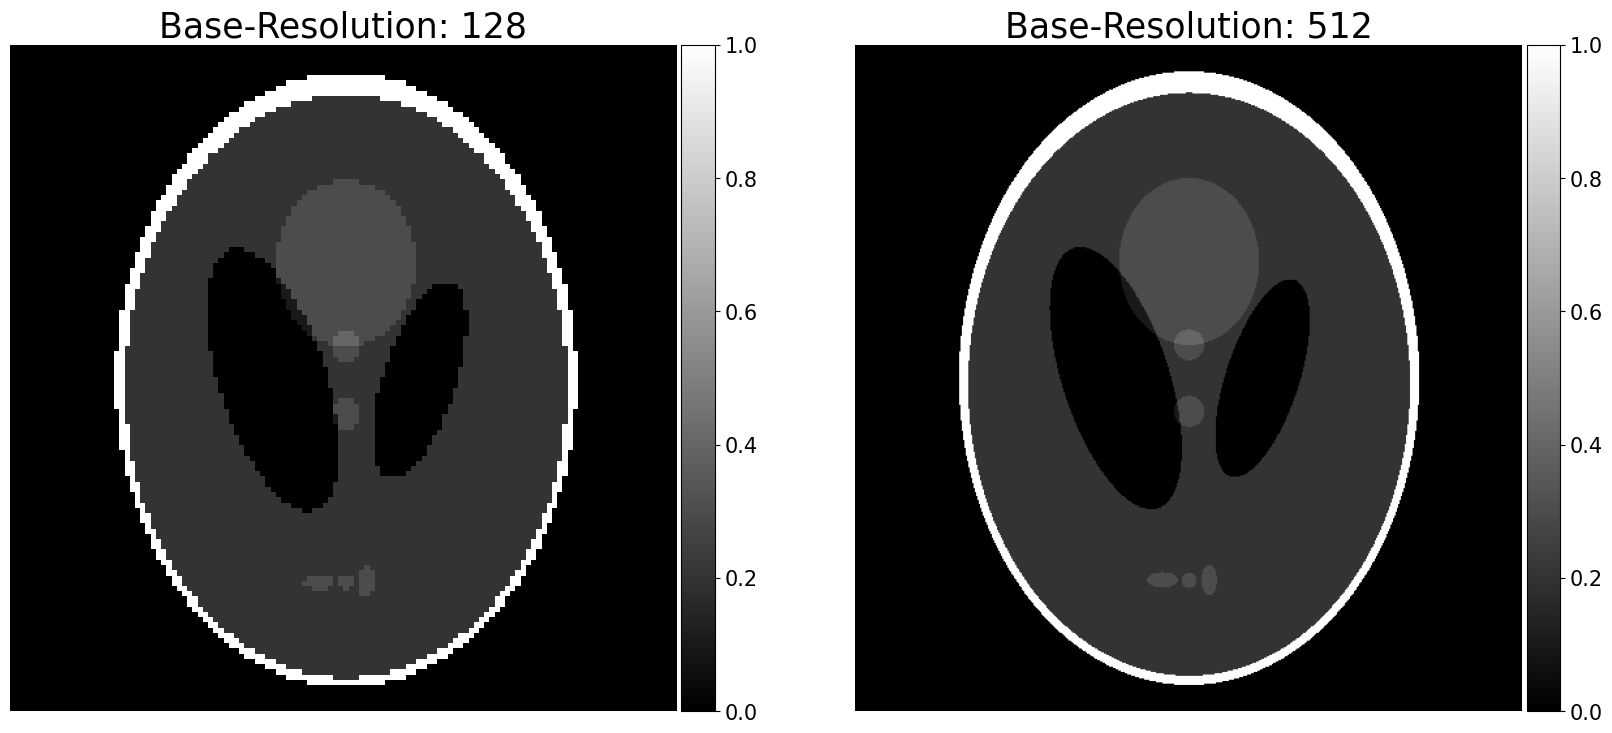

In [ ]:
# Rotate phantoms for visualization
!bart transpose 0 1 p pt
!bart transpose 0 1 p2 p2t

# Visualize the two phantoms that were simulated with different base resolutions
imshow(["pt", "p2t"], ["Base-Resolution: 128", "Base-Resolution: 512"])

The lower resolution simulation shows rectangular edges resulting from a simulation in the spatial domain.

By exploiting the analytical Fourier transform of ellipses, the simulation can be performed natively in the frequency domain and sampled on arbitrary trajectories.

Arbitrary trajectories are passed by `-t <traj-file>`, but first we assume the default fully-sampled Cartesian sampling.

A simulation in frequency space is performed by adding the flag `-k` to the `phantom` command.

In [ ]:
%%bash

# Simulation of a phantom in SPATIAL domain
bart phantom spa

# Simulation in FREQUENCY domain
bart phantom -k ksp

# For better visualization the frequency data is inverse Fourier transformed
bart fft -i 7 ksp reco

Both is visualized next to each other.

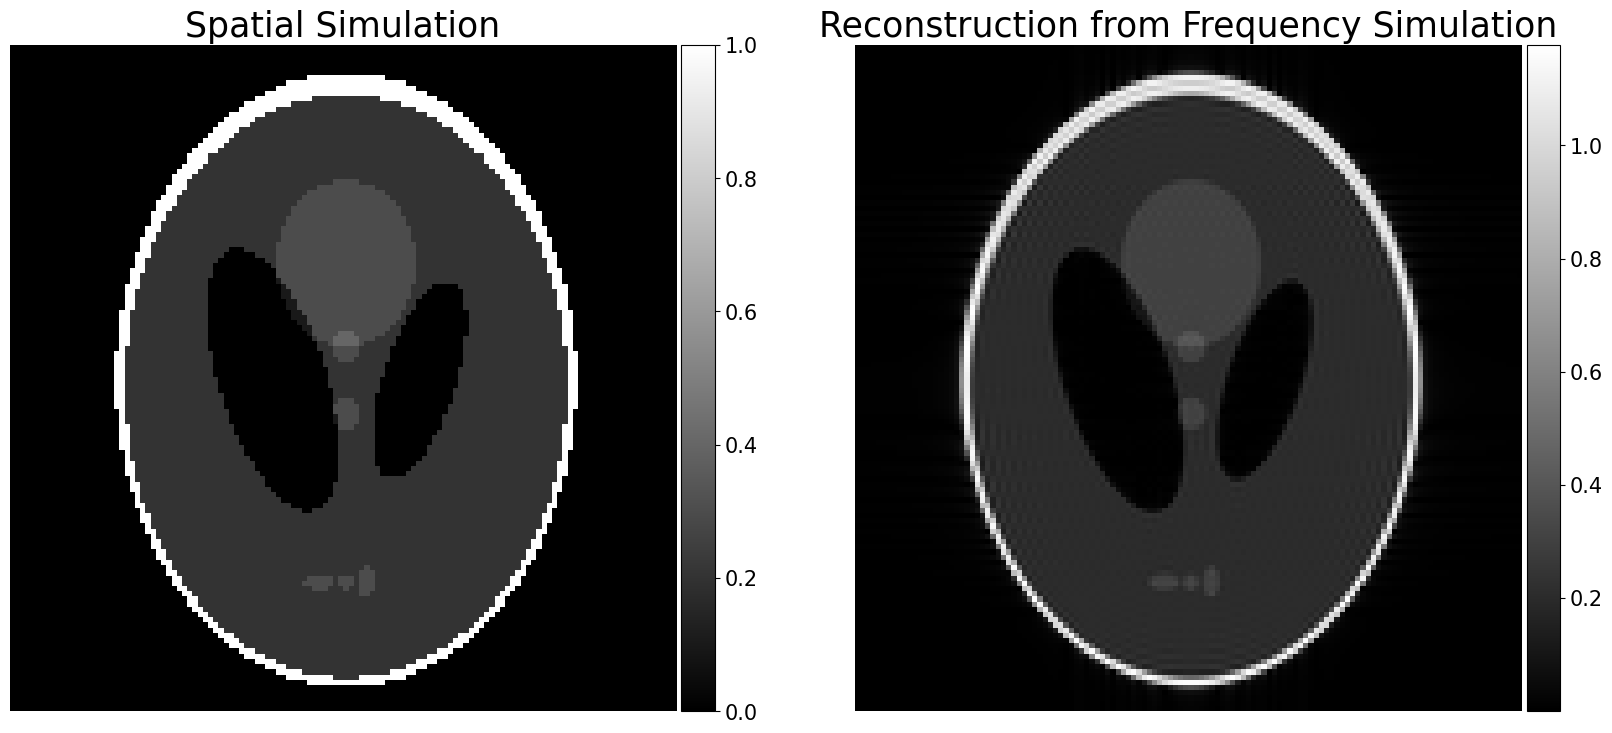

In [ ]:
# Rotate for visualization
!bart transpose 0 1 spa spat
!bart transpose 0 1 reco recot

imshow(["spat", "recot"], ["Spatial Simulation", "Reconstruction from Frequency Simulation"])

Here, both simulation are performed with the default base-resolution.

The reconstructed image from the frequency simulation shows the characteristic **Gibbs ringing artifacts**.

## Existing Geometries

The `phantom` tool already provides many already implemented geometries.
In the following, a selection of 2D and 3D geometries is introduced.

#### 2D Geometries

The highlighted 2D geometries cover the T2 sphere of the **NIST phantom** (model 130), the **BART logo**, and a 4 component **realistic brain** geometry.
The individual geometries are specified with the flags `--NIST`, `-B`, and `--BRAIN`, respectively.

In [ ]:
%%bash

# Creation of NIST phantom in spatial domain
bart phantom --NIST -x256 nist_sp

# Creation of BART phantom in spatial domain
bart phantom -B bart_sp

# Creation of BRAIN phantom in spatial domain
bart phantom --BRAIN brain_sp 

# Creation of NIST phantom in Fourier domain with reconstruction
bart phantom --NIST -x256 -k ksp
bart fft -i 7 ksp nist_reco

# Creation of BART phantom in Fourier domain with reconstruction
bart phantom -B -k ksp
bart fft -i 7 ksp bart_reco

# Creation of BRAIN phantom in Fourier domain with reconstruction
bart phantom --BRAIN -k ksp
bart fft -i 7 ksp brain_reco

Again the simulations can be performed in spatial and frequency domain.

##### Spatial Simulation

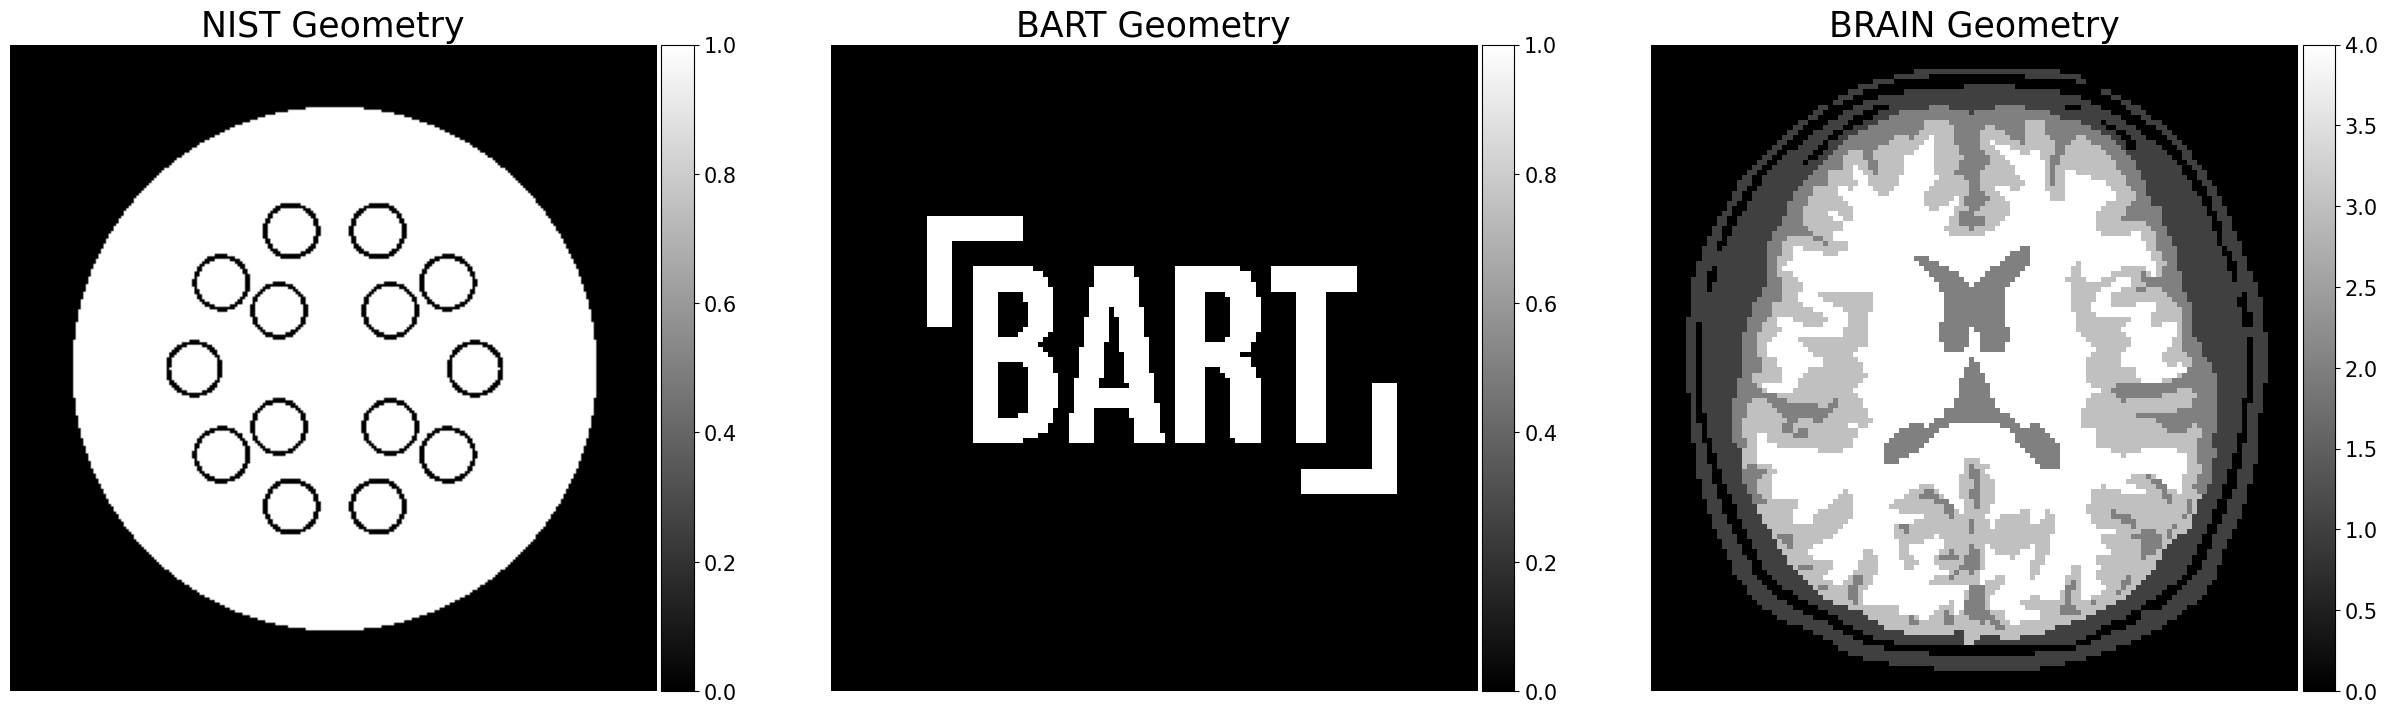

In [ ]:
imshow(["nist_sp", "bart_sp", "brain_sp"], ["NIST Geometry", "BART Geometry", "BRAIN Geometry"])

##### Reconstruction from Frequency Simulation

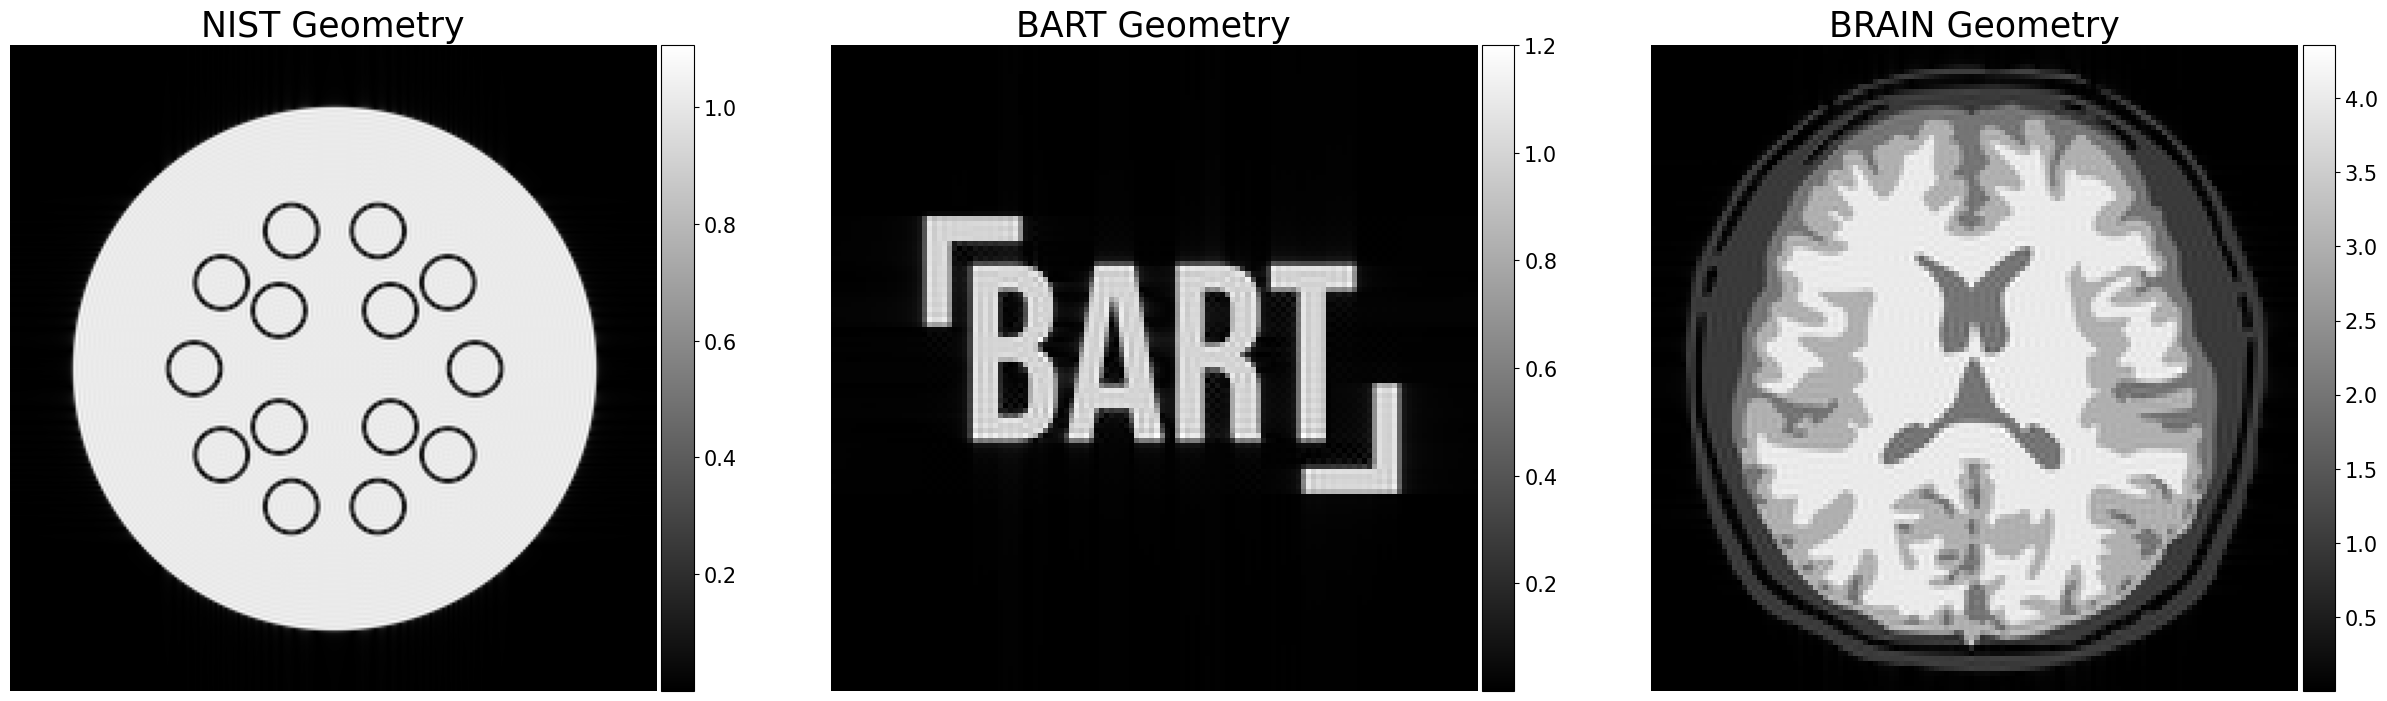

In [ ]:
imshow(["nist_reco", "bart_reco", "brain_reco"], ["NIST Geometry", "BART Geometry", "BRAIN Geometry"])


#### 3D Geometries

In addition to the 2D geometries an additional 3D version of the Shepp-Logan phantom is implemented.
Because the Shepp-Logan geoemtry is the default geometry in the `phantom` tool only the flag `-3` needs to be added to create a 3D object.

In [ ]:
%%bash

# 3D Shepp-Logan phantom in spatial domain
bart phantom -3 spa

# 3D Shepp-Logan phantom in frequency domain
bart phantom -3 -k ksp
bart fft -i 7 ksp reco

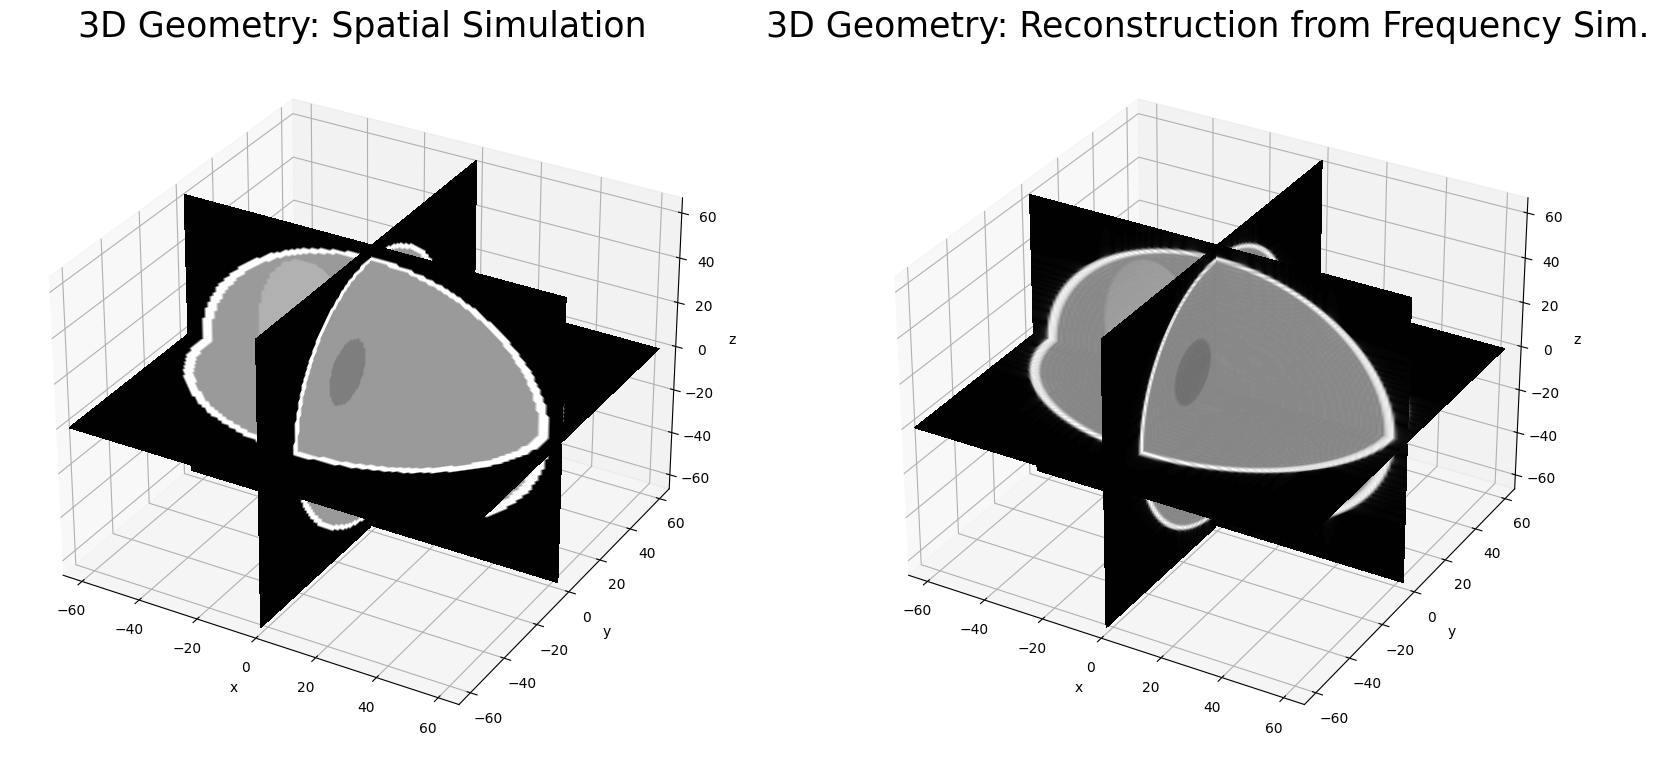

In [ ]:
imshow3d(["spa", "reco"], ["3D Geometry: Spatial Simulation", "3D Geometry: Reconstruction from Frequency Sim."])


## Import own SVG Geometries

<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2023/digital-objects/figures/spline_theory.svg?raw=1" width=1000>

Geometries like the `BRAIN` phantom, the `BART` logo or the flower in the figure above can analytically be represented as
$$
\rho(r) = \sum_{i=0}^{R-1} \rho_i \mathrm{1}_{\mathcal{R}_i}(r), r\in\mathbb{R},
$$
where $\mathcal{R}_i$ describes the $i$-th petal containing constant values $\rho_i(r)\in\mathbb{C}\forall r\in\mathcal{R}_i$.

In the spatial domain, the boundary $b_i$ of all $\mathcal{R}_i$ is parametrized by the set of control points $\{c_k^i\}_{k=1}^{N_i}$ with the help of Bézier curves
$$
b_i(t) = \sum_{k=0}^{N_i} c_k^i \mathcal{B}_{k,N_i}(t) \approx \sum_{j=0}^{M_i} d_j^i P_j^i(t) =: P_i(t), t\in[0,1],
$$
and each boundary curve $b_i$ is approximated by polynomials $P_i$ whose analytical Fourier transform $\mathcal{F}(P_i)$ is known.

Both $P_i$ and $\mathcal{F}(P_i)$ can be sampled on arbitrary trajectories in spatial and Fourier domain, respectively.

To allow a simple integration of arbitrary phantom geometries in the `phantom` tool it provides an option to pass a file including the control points of the Bézier curves $\{c_k^i\}_{k=1}^{N_i}$ that are rendered by BART afterwards.

A geometry can be designed with powerful tools like [Inkscape](https://inkscape.org) and should be saved in the SVG format.
Using a by BART provided extraction tool (located at `$TOOLBOX_PATH/python/splines_from_svg.py`) the control points $\{c_k^i\}_{k=1}^{N_i}$ and corresponding meta information of the design can be extracted.
They are stored in multi-cfl files and can be passed to the `phantom` tool with the `--FILE <filename>` flag.


<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2023/digital-objects/figures/workflow.svg?raw=1" width=1400>


Let us focus on the individual steps in detail.

First, a geometry is designed in [Inkscape](https://inkscape.org).

The geometry is:

<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2023/digital-objects/data/flower.svg?raw=1" width=400>

Afterwards, the extraction tool `splines_from_svg.py` can be called from its location `${TOOLBOX_PATH}/python/`.
By adding `-h` some help can be generated.

In [ ]:
%%bash

# Call the tool to extract the control points of the splines from an SVG file
python3 ${TOOLBOX_PATH}/python/splines_from_svg.py -h

usage: splines_from_svg.py [-h] [-d DB] input output

Script to extract control points of cubic Hermite splines from SVG file to CFL
format.

positional arguments:
  input           Input SVG file
  output          Output CFL filename

options:
  -h, --help      show this help message and exit
  -d DB, --db DB  Specify debug value for additional information [default: 0]


The extraction of the control points is performed with:

In [ ]:
%%bash

# For additional debugging information a DEBUG_LEVEL can be set in the shell
# export DEBUG_LEVEL=1
# or specified by the `-d` flag

# Convert SVG geometry to multi cfl file
python3 ${TOOLBOX_PATH}/python/splines_from_svg.py -d 1 data/flower.svg plant


Created files:
plant.{cfl,hdr}


The resulting output is a multi-cfl file, here called "plant", with the extracted control point from the original svg file, called "flower".

A multi-cfl file consists, similar to BART's conventional cfl format, of a data file in `*.cfl` format and a header in `*.hdr`.
They can store multiple ordinary cfl files.
Their dimensions can be found in the corresponding header file:

In [ ]:
%%bash

cat plant.hdr


# Dimensions
1313
# SizesDimensions
3 2 
# MultiDimensions
160 2 4 
11 3 


The first has the dimensions `160 2 4` and contains the control points for the individual paths of the splines.
The second contains meta information like the paths lengths and color values of the different segments of the drawing.

Next, this multi-cfl file can be passed to the `phantom` tool with `--FILE <filename>`.

In [ ]:
%%bash

# Simulation of geometry specified in file "flower" in spatial domain
bart phantom --FILE plant sp

# Simulation of geometry specified in file "flower" in frequency domain
bart phantom --FILE plant -k ksp
bart fft -i 7 ksp reco

The geometry can be simulated natively in the frequency domain providing arbitrary sampling shemes with the realistic artifacts.

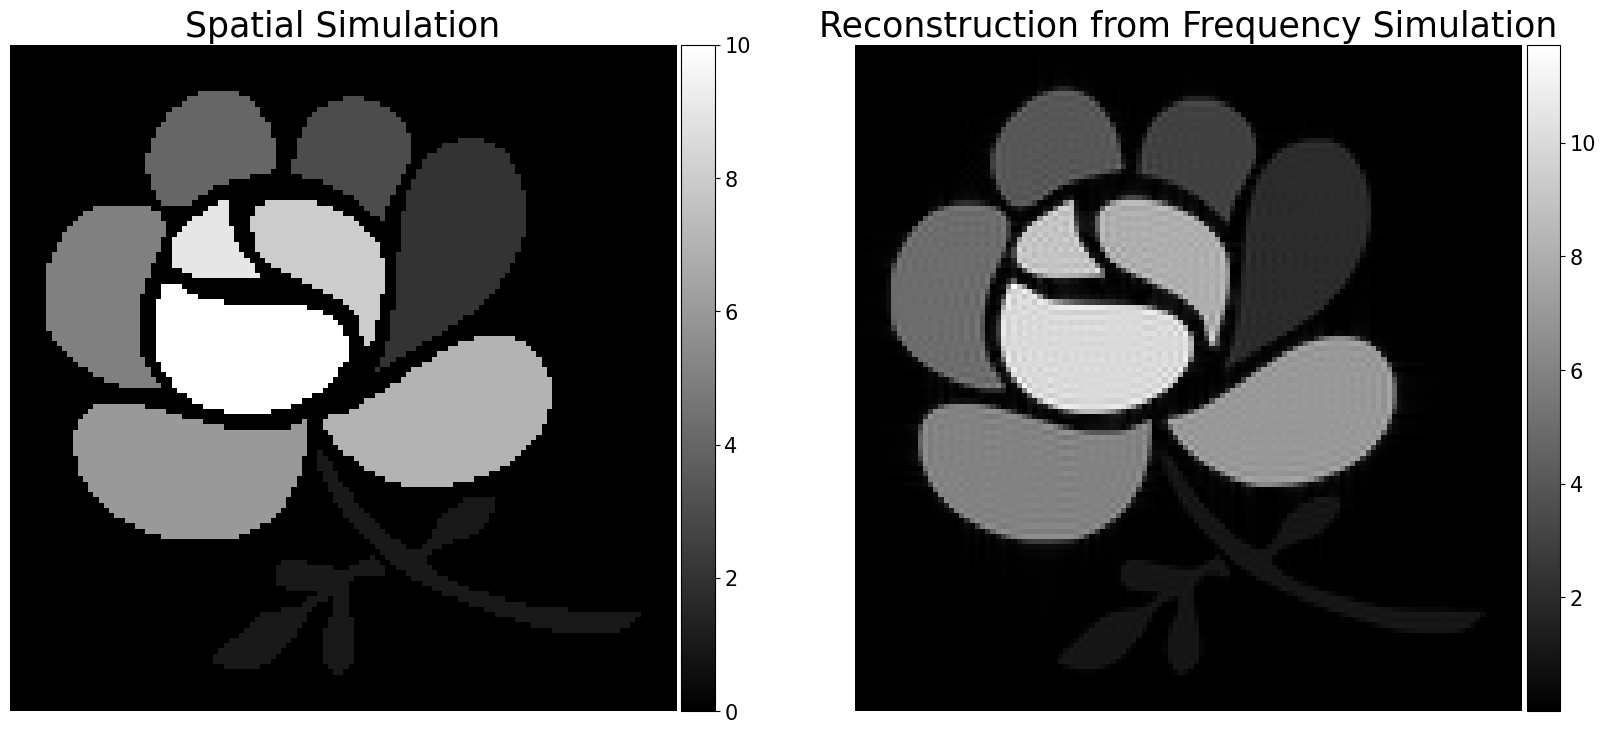

In [ ]:
imshow(["sp", "reco"], ["Spatial Simulation", "Reconstruction from Frequency Simulation"])

## Realistic Coil Sensitivity Simulations

After presenting some already implemented geometries and introducing a workflow to simulate custom geometries with BART's `phantom` tool
in the next step the simulation of realistic coil sensitivity profiles is shown.


#### Theory

Let us give some theoretical background on how to simulate realistic coil signals for the case of 2D or 3D signals with $k=1,...,64$ receiver coil channels.
The sensitivity profiles $s_k$ of the $k$-th coil are smooth functions, therefore one can represent them by few Fourier coefficients e.g. over the following set of frequencies

$$
\text{supp}\{\mathcal{F}(s_k)\} = \{-2,-1,0,1,2\}^3 =: \mathcal{S}.
$$

The set of Fourier coefficients $\{\mathcal{F}(s_k)(\delta)\}_{k=1,...,64,\delta\in\mathcal{S}}$ is available in BART.
Simulating a realistic signal of the $k$th coil in the spatial domain reduces to the evaluation of the product

$$
\rho(r) \cdot s_k(r)
$$

on e.g. a Cartesian grid $r\in\mathcal{Z}^3$.
The simulations can also be performed in the Fourier domain

$$
\mathcal{F}(\rho\cdot s_k)(\omega) = \mathcal{F}(\rho) * \mathcal{F}(s_k) = \sum_{\delta\in\mathcal{S}} \mathcal{F}(\rho)(\omega - \delta) \cdot \mathcal{F}(s_k)(\delta),
$$

where in the first equation the Fourier convolution theorem is applied and one obtains the last equation by using the definition of the convolution and realizing that $\mathcal{F}(s_k)(\delta) = 0$ if $\delta\not\in\mathcal{S}$ by construction.

Therefore, the expression $\mathcal{F}(\rho\cdot s_k)(\omega)$ can be cheaply computed on any trajectory $\{\omega_1,...\}\subset \mathcal{R}^d$ for each coil $k=1,...,64$ in any dimension 2D or 3D.


The `phantom` tool provides a simple interface to simulate these 2D and 3D sensitivities. While both can be used for all geometries, it is not recommended using the 2D sensitivities for 3D geometries.


#### Basics

Currently, two types of coils can be simulated with BART.
They can be chosen individually with the `phantom` tools `--coil` interface.

In [ ]:
%%bash

bart phantom --coil h

Usage of sub-option: --coil [HEAD_2D_8CH],[HEAD_3D_64CH]

Sub-options: configure type of coil

HEAD_2D_8CH     2D head coil with up to 8 channels
HEAD_3D_64CH    3D head coil with up to 64 channels
h               help


Both datasets are extracted from phantom measurements using head coils.
If you do not specify any of them a 2 dimensional set with up to 8 channels (`HEAD_2D_8CH`) is the default for 2D geometries and a 3D set with up to 64 channels for 3D geometries (`HEAD_3D_64CH`).


#### Realistic Coil Sensitivities with 2D Geometries

The number of simulated coils is specified with `-s <number>`. By choosing `-S <number>` only the coils are simulated without the geometry.

For the 2D sensitivities up to 8 channels can be chosen.

In the following cell, eight profiles are simulated (`-s8`) but only three are visualized.

In [ ]:
%%bash

# Estimation of sensitivity profiles
bart phantom -S8 sens 

# Extraction of individual profiles for visualization
bart slice 3 0 sens sens0
bart slice 3 4 sens sens1
bart slice 3 7 sens sens2

# Simulation of BRAIN phantom with sensitivity profiles in spatial domain
bart phantom --BRAIN -s8 sp 

# Extraction of individual coil images for visualization
bart slice 3 0 sp sp0
bart slice 3 4 sp sp1
bart slice 3 7 sp sp2

The individual profiles are:

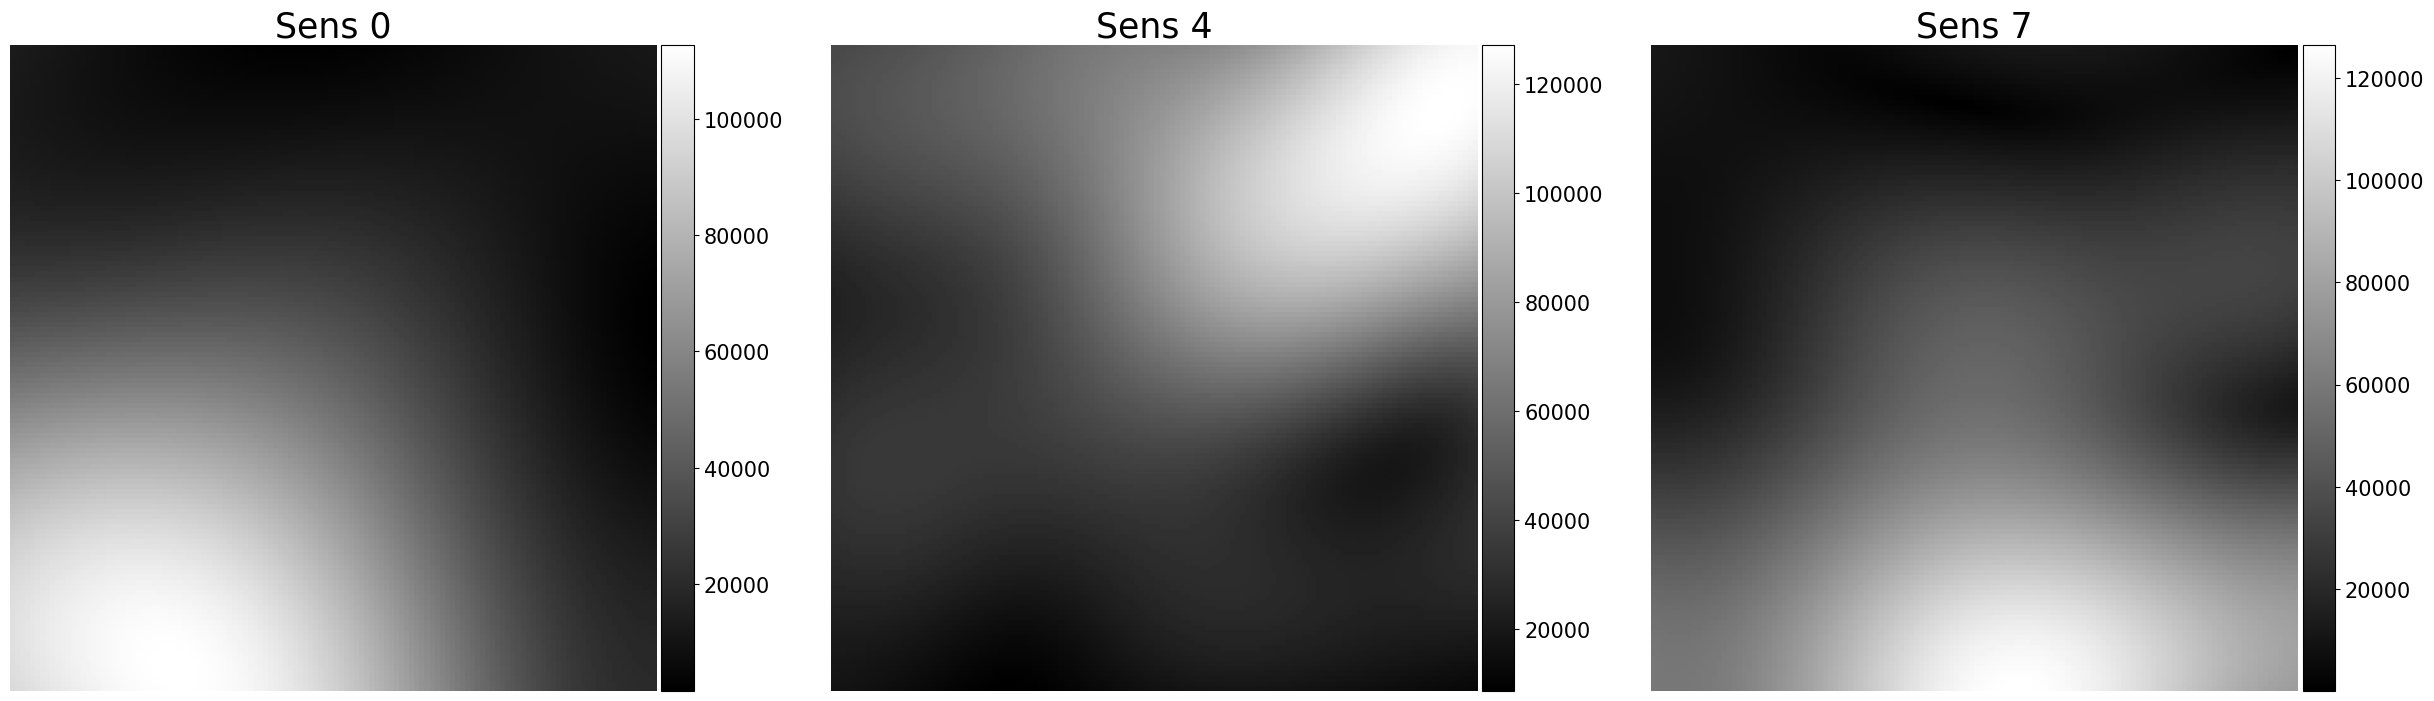

In [ ]:
imshow(["sens0", "sens1", "sens2"], ["Sens 0", "Sens 4", "Sens 7"])

while the simulated objects in spatial domain are:

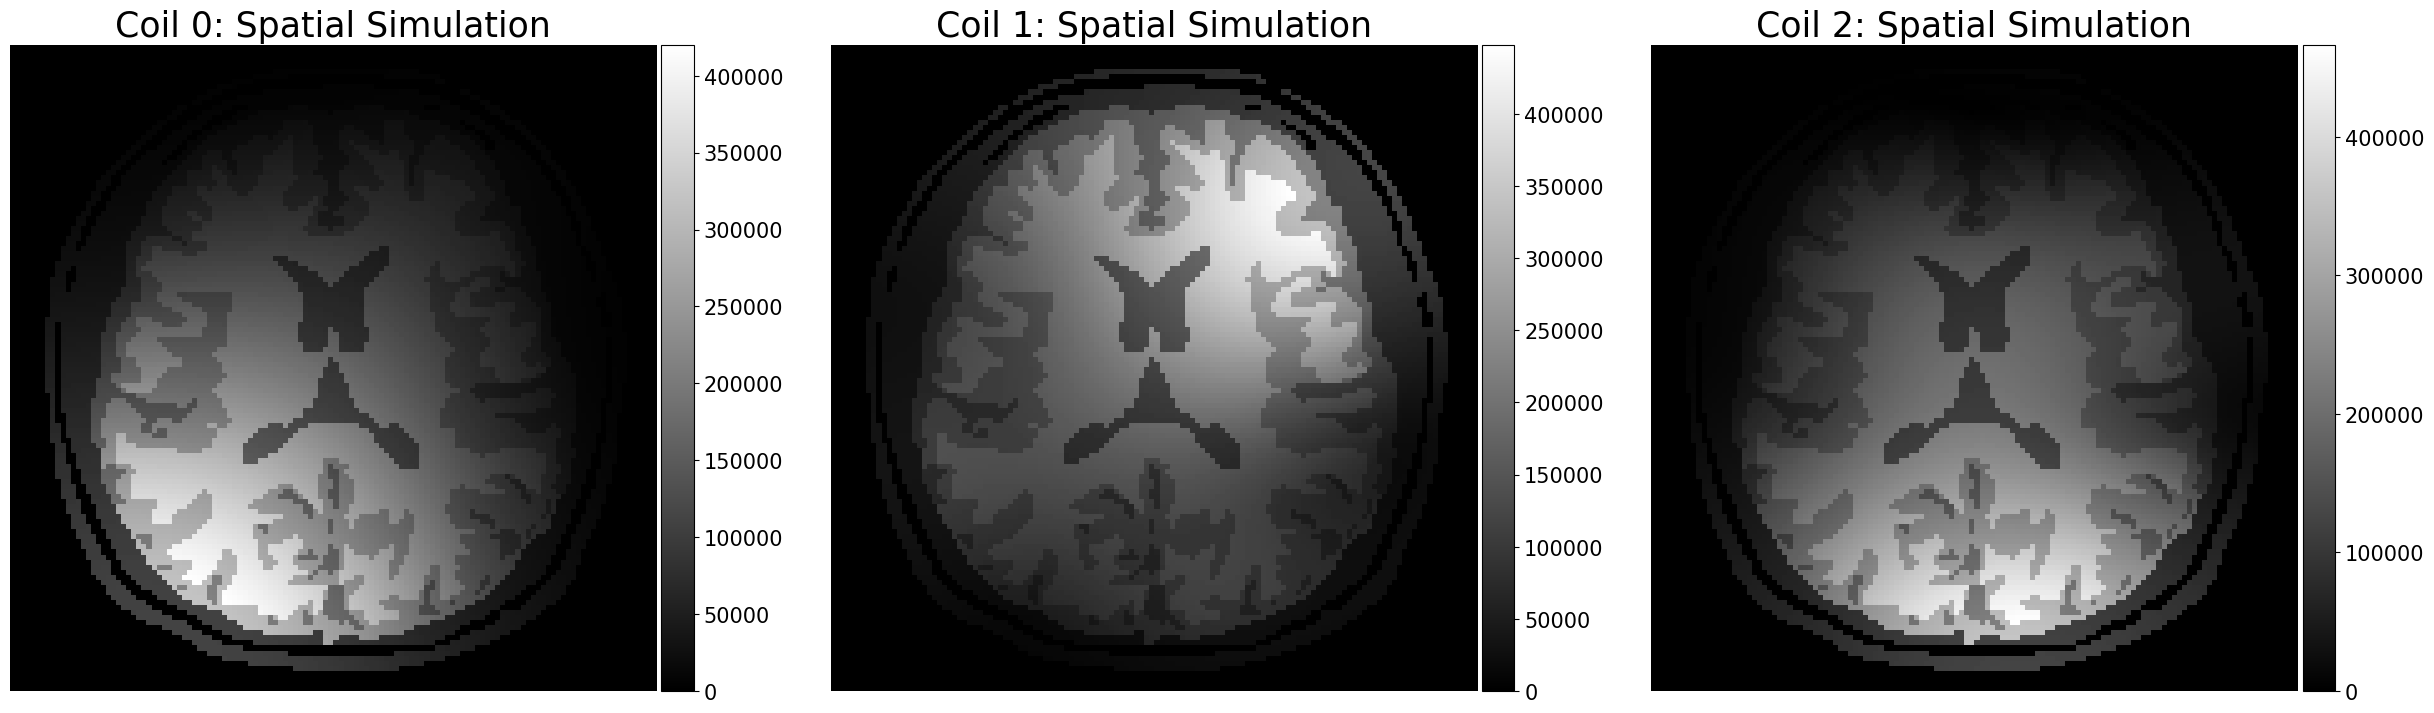

In [ ]:
imshow(["sp0", "sp1", "sp2"], ["Coil 0: Spatial Simulation", "Coil 1: Spatial Simulation", "Coil 2: Spatial Simulation"])

The simulation of coil profiles can also be performed in frequency domain, but is too computationally expensive to run it on binder or Google Colab.

In [ ]:
%%bash

# Simulation of BRAIN phantom with sensitivity profiles in frequency domain
## Look out! This is computationally expensive and not recommended to run online
## Run times on local machines were in the order of multiple minutes

# bart phantom --BRAIN -s3 -k ksp
# bart fft -i 7 ksp reco

# bart slice 3 0 reco reco0
# bart slice 3 1 reco reco1
# bart slice 3 2 reco reco2

In [ ]:
# imshow(["sp0", "sp1", "sp2"],["Coil 0: Reconstruction from Freq. Sim.", "Coil 1: Reconstruction from Freq. Sim.", "Coil 2: Reconstruction from Freq. Sim."])

#### Realistic Coil Sensitivities with 3D Sensitivities

The 3D sensitivies are the default for 3D geometries.
They incorporate up to 64 different channels.


In [ ]:
%%bash

# Estimate the 3D sensitivity profiles
bart phantom -3 -S3 sens 

# Slice them for visualization
bart slice 3 0 sens sens0
bart slice 3 1 sens sens1
bart slice 3 2 sens sens2

# Simulate the 3D Shepp-Logan phantom with 3D sensitivities
bart phantom -3 -s3 sp 

# Slice them for visualization
bart slice 3 0 sp sp0
bart slice 3 1 sp sp1
bart slice 3 2 sp sp2

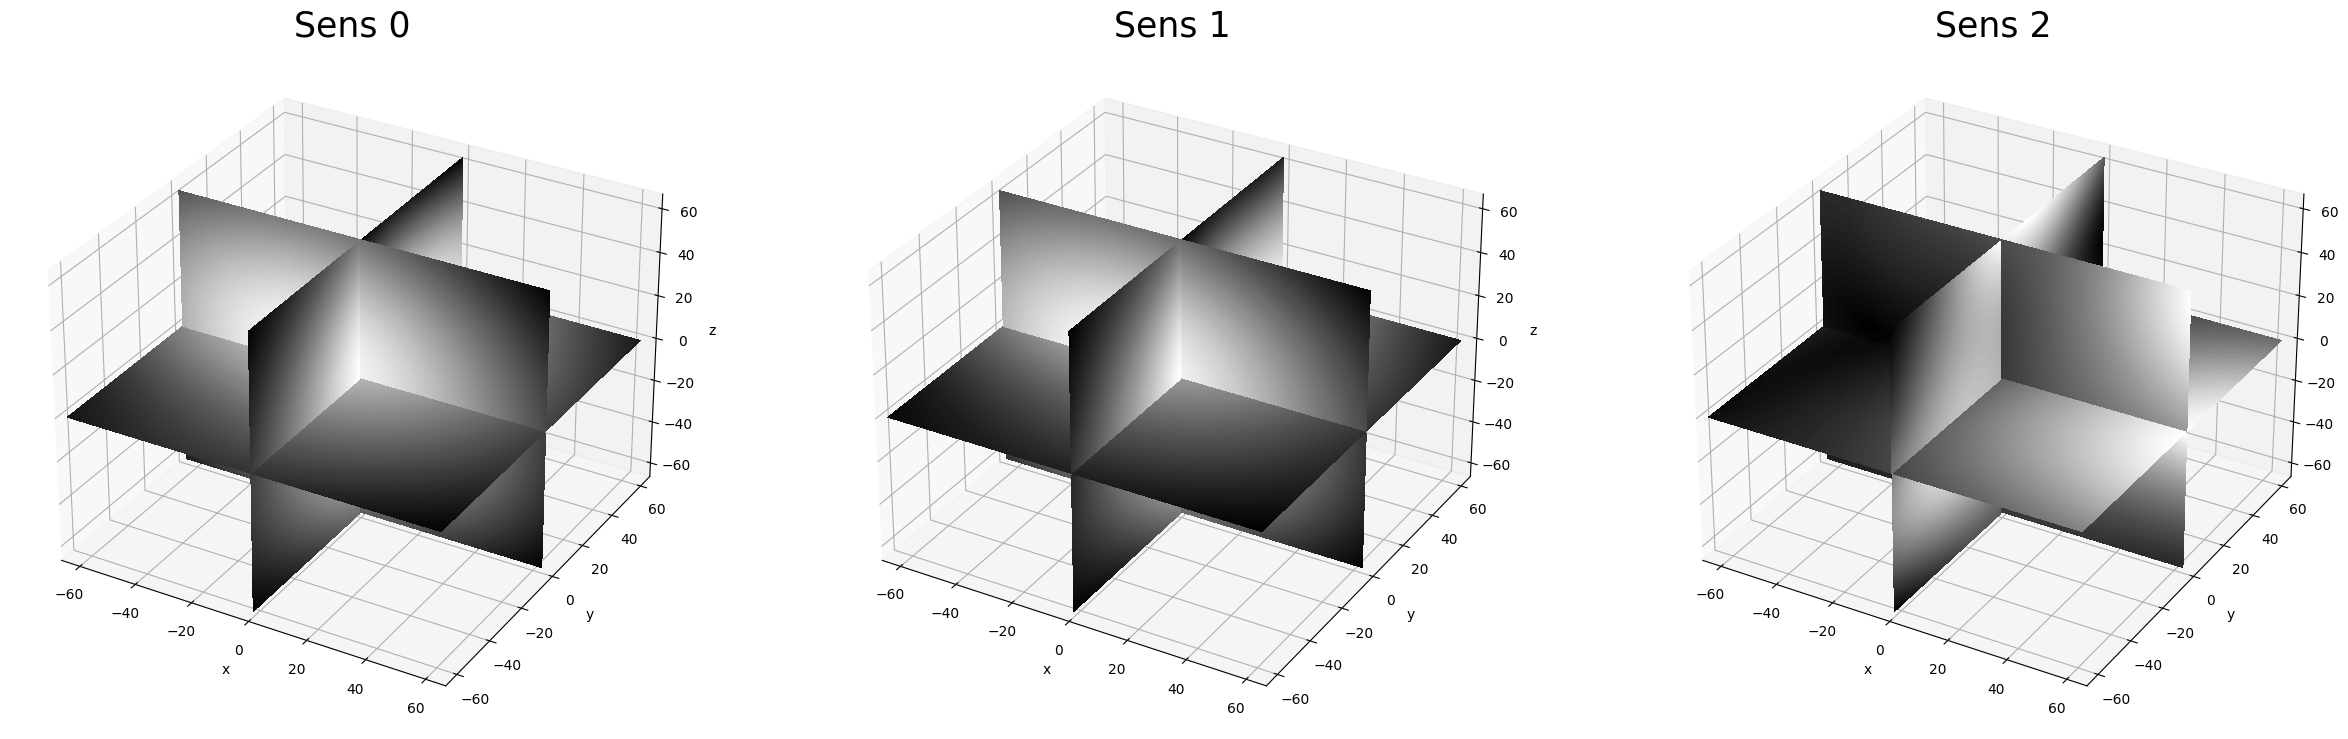

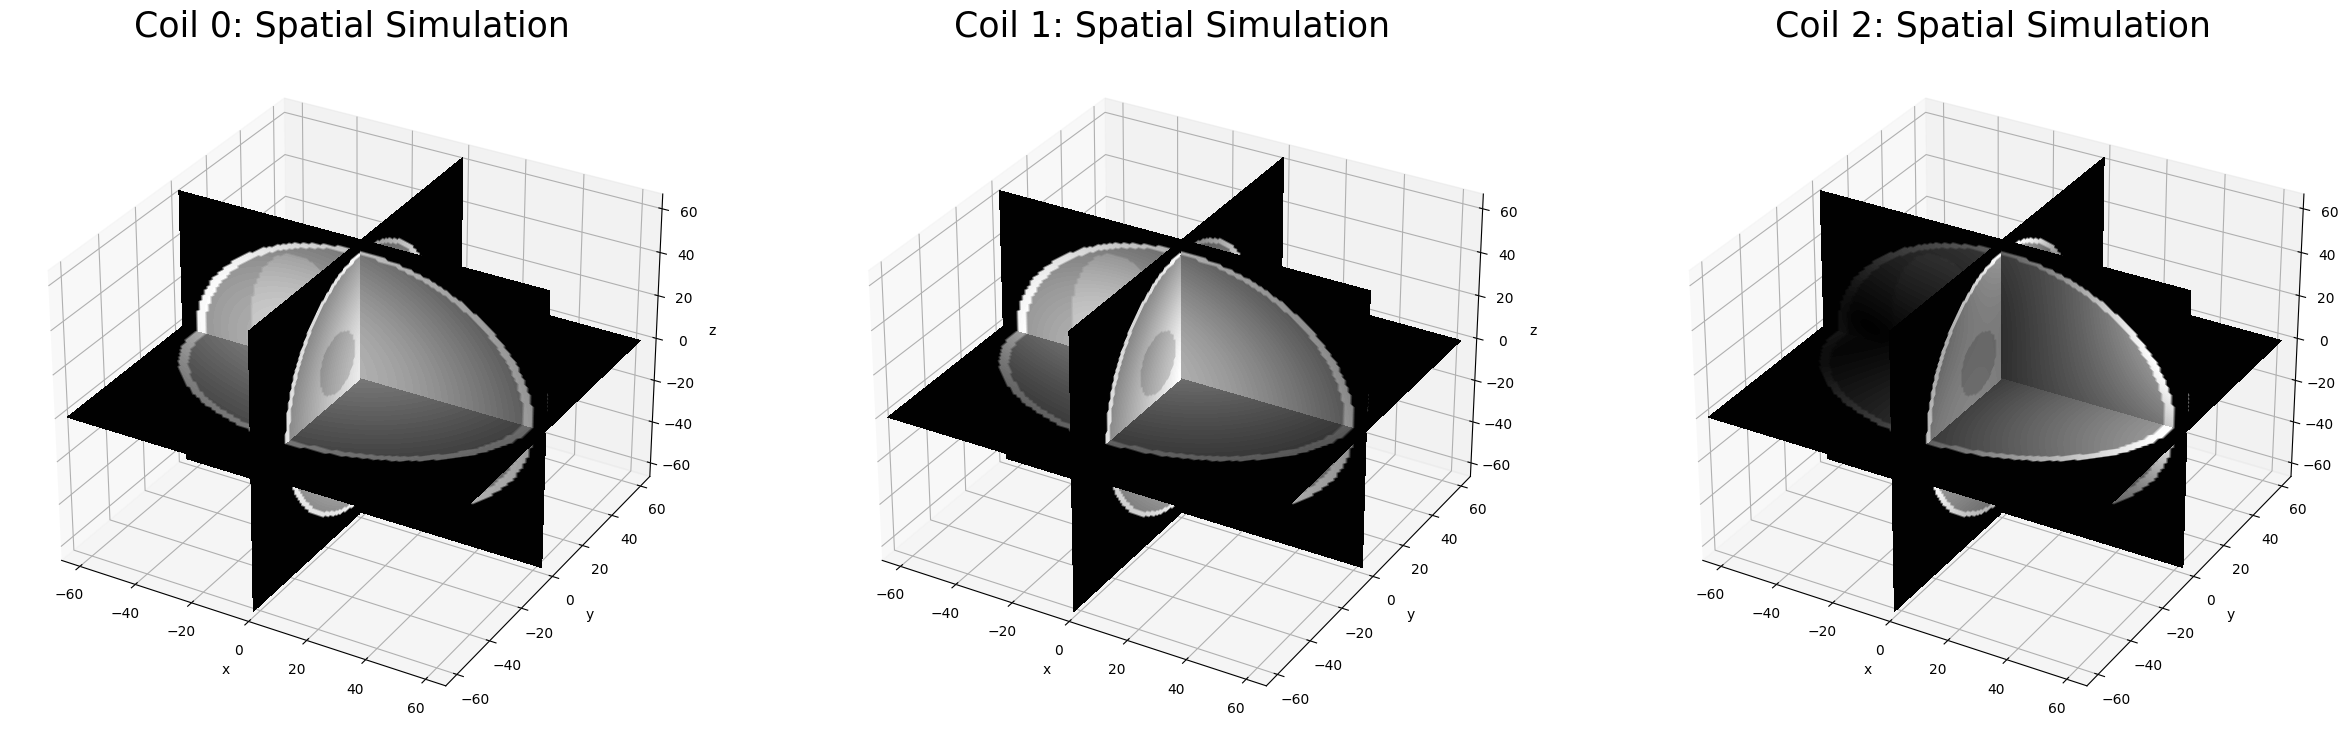

In [ ]:
imshow3d(["sens0", "sens1", "sens2"], ["Sens 0", "Sens 1", "Sens 2"])

imshow3d(["sp0", "sp1", "sp2"], ["Coil 0: Spatial Simulation", "Coil 1: Spatial Simulation", "Coil 2: Spatial Simulation"])

## Synthetic MRI Simulations

Besides the options to simulate in frequency domain and realistic coil sensitivity profiles, the `phantom` tool can split different geometries in their geometrical components.

This works for the internal **BRAIN**, **TUBES**, **SONAR**, and **BART** geometry but is also supports by the arbitrary design import with `--FILE <geomfile>`.

The split into the components is performed by adding the `-b` flag.

In [ ]:
%%bash

# Simulation of BRAIN geometry in spatial domain with component splitting
bart phantom --BRAIN -b spa

# Extraction of individual profiles for visualization
bart slice 6 0 spa spa0
bart slice 6 1 spa spa1
bart slice 6 2 spa spa2
bart slice 6 3 spa spa3

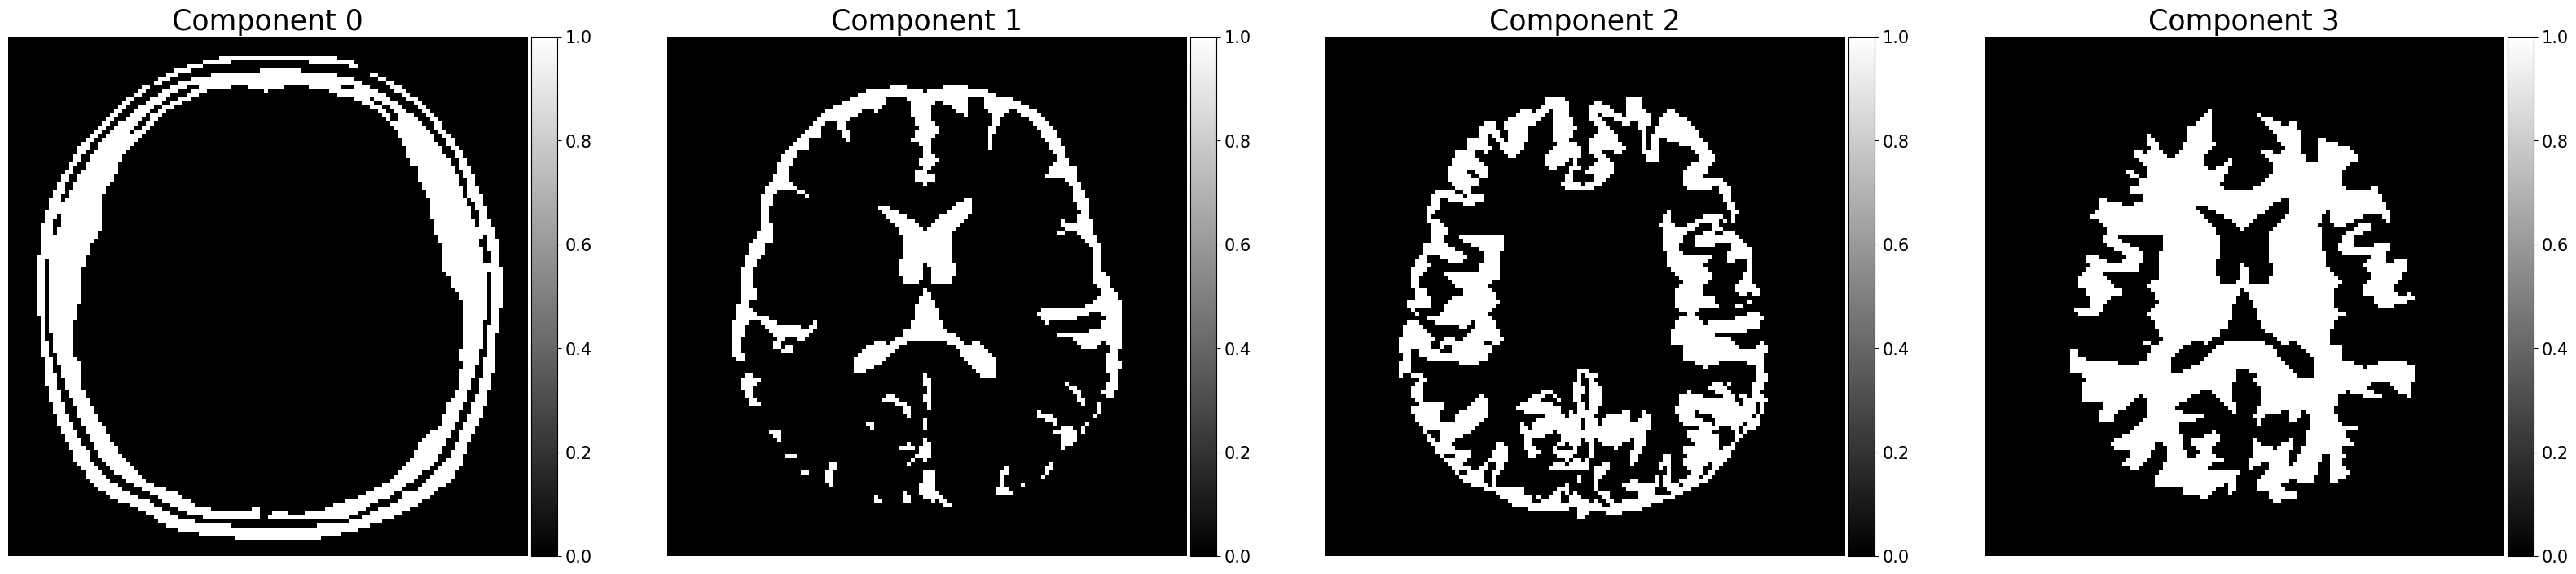

In [ ]:
imshow(["spa0", "spa1", "spa2", "spa3"], ["Component 0", "Component 1", "Component 2", "Component 3"])

The splitting can be combined with the simulation of coils and can be performed in frequency domain.
For complex geometries such as the BRAIN geometry it is computationally expensive and not recommended in this tutorial.

In [ ]:
%%bash

# Simulation of BRAIN geometry in frequency domain with component splitting
## Look out! This is computationally expensive and not recommended to run online
## Run times on local machines were in the order of multiple minutes

# bart phantom --BRAIN -b -k -s2 ksp
# bart slice 3 0 ksp ksp2

# # Reconstruction for visualization
# bart fft -i 7 ksp2 reco

# # Extraction of individual profiles for visualization
# bart slice 6 0 reco reco0
# bart slice 6 1 reco reco1
# bart slice 6 2 reco reco2
# bart slice 6 3 reco reco3

In [ ]:
# imshow(["reco0", "reco1", "reco2", "reco3"], ["Component 0", "Component 1", "Component 2", "Component 3"])

The simulation including a realistic coil profile, a frequency domain simulation and a component split is demonstrated for the less complex NIST phantom geometry because of its reduces computational costs.

In [ ]:
%%bash

# Simulation of BRAIN geometry in spatial domain with component splitting
bart phantom --NIST -b -k -s2 ksp
bart slice 3 0 ksp ksp2

# Reconstruction for visualization
bart fft -i 7 ksp2 reco

# Extraction of individual profiles for visualization
bart slice 6 0 reco reco0
bart slice 6 1 reco reco1
bart slice 6 2 reco reco2
bart slice 6 3 reco reco3

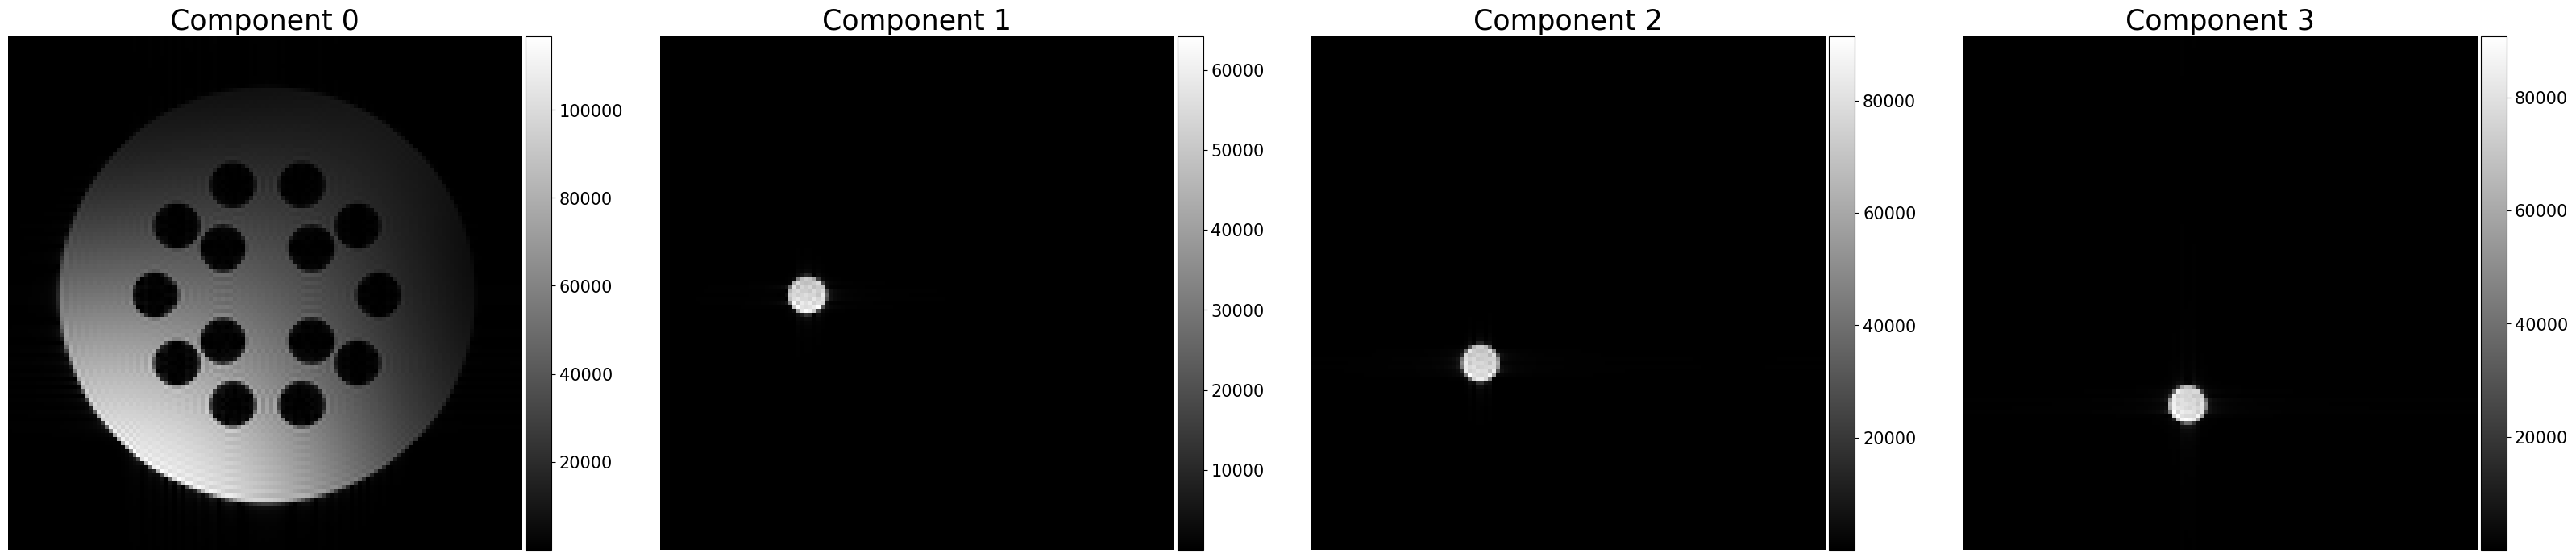

In [ ]:
imshow(["reco0", "reco1", "reco2", "reco3"], ["Component 0", "Component 1", "Component 2", "Component 3"])

All in all, the feature of splitting the geometries into their individual components can be used to create realistic synthetic MRI datasets with BART.

<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2023/digital-objects/figures/component_time.png?raw=1" width=1600>

For each individual component a signal is simulated with a Bloch simulation.
This tutorial makes use of BART's internal Bloch simulator.
A detailed introduction and interactive tutorial can be found on [Github](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2022).

The simulated signals are point-wise multiplied with the corresponding geometric component.
Afterwards, the sum over all geometric components is calculated.
Due to the linearity of the Fourier transform this operatrion can be performed in spatial and frequency domain creating a versatile tool for simulating
synthetic MRI data with realistic signal evolution, frequency domain artifacts, coil simulations and geometries.

Additionally, the frequency space data can be sampled on arbitrary trajectories.
In the following example a radial trajectory is created with BART's `traj` tool using the `-r` flag.
By passing the trajectory file to the `phantom` tool using `-t <traj-file>` the simulated data is sampled on the provided trajectory.

In [9]:
%%bash

## Relaxation parameters for Brain phantom
T1=(0.6 3 1.5 0.8)
T2=(0.08 1 0.06 0.1)

# Simulation Parameters
#       Run `bart sim --seq h` for more details
SEQ=IR-FLASH    # Sequence Type
TR=0.0034       # Repetition Time [s]
TE=0.0021       # Echo Time [s]
REP=600         # Number of repetitions
IPL=0.01        # Inversion Pulse Length [s]
ISP=0.005       # Inversion Spoiler Gradient Length [s]
PPL=0           # Preparation Pulse Length [s]
TRF=0.001       # Pulse Duration [s]
FA=6            # Flip Angle [degree]
BWTP=4          # Bandwidth-Time-Product
OFF=0           # Off-Resonance [rad/s]
SLGRAD=0        # Slice Selection Gradient Strength [T/m]
SLTHICK=0       # Thickness of Simulated Slice [m]
NSPINS=1        # Number of Simulated Spins

# Run Simulations

## 0th component
bart sim --ODE \
	--seq $SEQ,TR=$TR,TE=$TE,Nrep=$REP,ipl=$IPL,isp=$ISP,ppl=$PPL,Trf=$TRF,FA=$FA,BWTP=$BWTP,off=$OFF,sl-grad=$SLGRAD,slice-thickness=$SLTHICK,Nspins=$NSPINS \
	-1 ${T1[0]}:${T1[0]}:1 -2 ${T2[0]}:${T2[0]}:1 \
	_simu00

## 1st component
bart sim --ODE \
	--seq $SEQ,TR=$TR,TE=$TE,Nrep=$REP,ipl=$IPL,isp=$ISP,ppl=$PPL,Trf=$TRF,FA=$FA,BWTP=$BWTP,off=$OFF,sl-grad=$SLGRAD,slice-thickness=$SLTHICK,Nspins=$NSPINS \
	-1 ${T1[1]}:${T1[1]}:1 -2 ${T2[1]}:${T2[1]}:1 \
	_simu01

## 2nd component
bart sim --ODE \
	--seq $SEQ,TR=$TR,TE=$TE,Nrep=$REP,ipl=$IPL,isp=$ISP,ppl=$PPL,Trf=$TRF,FA=$FA,BWTP=$BWTP,off=$OFF,sl-grad=$SLGRAD,slice-thickness=$SLTHICK,Nspins=$NSPINS \
	-1 ${T1[2]}:${T1[2]}:1 -2 ${T2[2]}:${T2[2]}:1 \
	_simu02

## 3rd component
bart sim --ODE \
	--seq $SEQ,TR=$TR,TE=$TE,Nrep=$REP,ipl=$IPL,isp=$ISP,ppl=$PPL,Trf=$TRF,FA=$FA,BWTP=$BWTP,off=$OFF,sl-grad=$SLGRAD,slice-thickness=$SLTHICK,Nspins=$NSPINS \
	-1 ${T1[3]}:${T1[3]}:1 -2 ${T2[3]}:${T2[3]}:1 \
	_simu03


# Join individual simulations
bart join 7 _simu00 _simu01 _simu02 _simu03 simu

# Join simulations in a single dimension (-> 6)
bart reshape $(bart bitmask 6 7) 4 1 simu simu2


# Simulated Spatial Components

DIM=192
GEOM_COMP=4
SAMPLES=96
SPOKES=95

## Create trajectory (RADIAL here `-r`)
bart traj -x $SAMPLES -y $SPOKES -r -o 2 traj

## Create phantom based on trajectory in FREQUENCY DOMAIN
bart phantom --BRAIN -b -k -t traj comp_geom_ksp

## Reconstruct the non-Cartesian k-space samples for better visualization
bart nufft -i -d $DIM:$DIM:1 traj comp_geom_ksp comp_geom_img

# Combine simulated Signal and reconstructed Components
bart fmac -s $(bart bitmask 6) comp_geom_img simu2 phantom_img


## Create phantom in SPATIAL DOMAIN
bart phantom --BRAIN -b -x $DIM comp_geom_sp
# Combine simulated Signal and Spatial Components
bart fmac -s $(bart bitmask 6) comp_geom_sp simu2 phantom_img2

0.034847
0.033917
0.035100
0.033590
Done.


##### Reconstruction from Non-Cartesian Frequency Domain Simulation

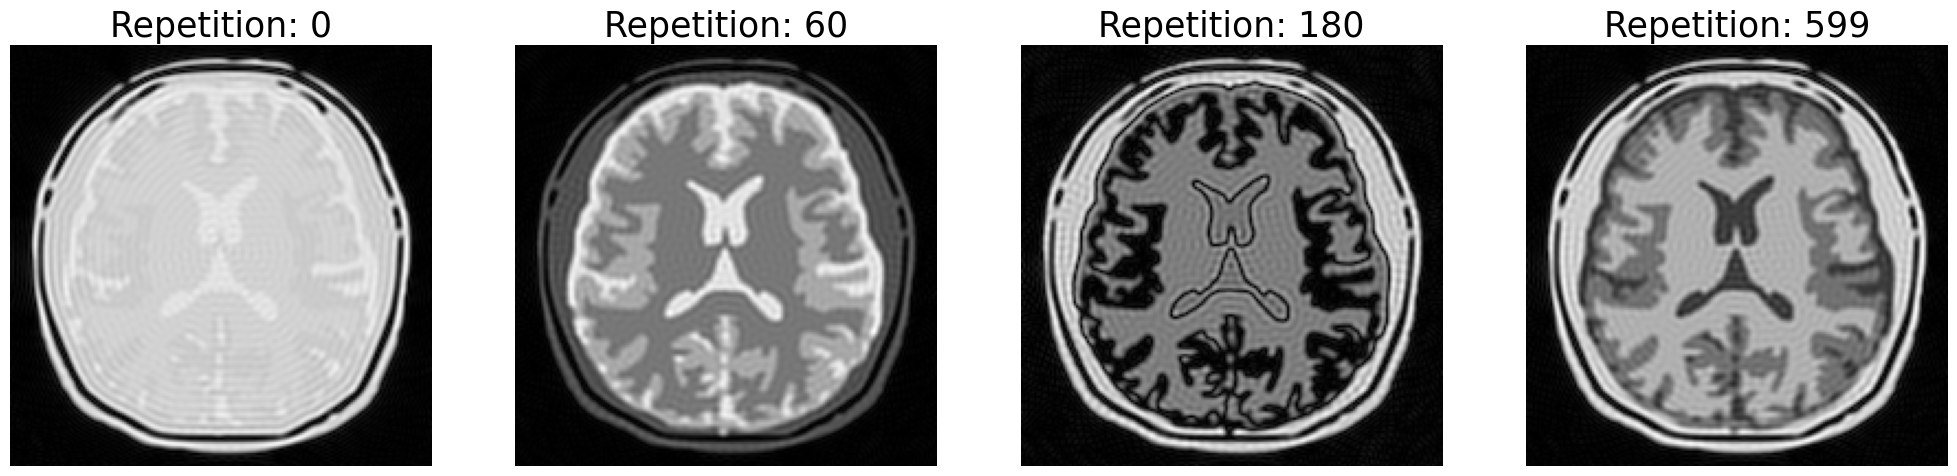

In [10]:
imshow_time('phantom_img', [0, 60, 180, 599])

##### Simulation in Spatial Domain Data

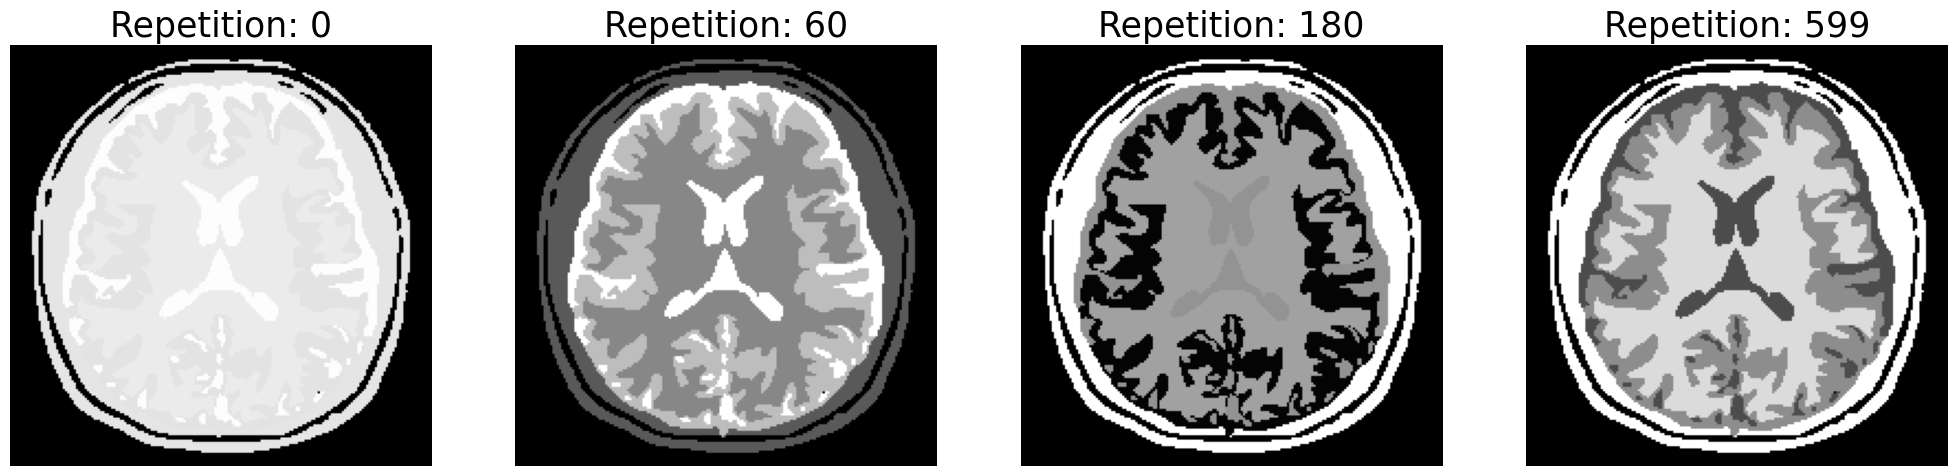

In [11]:
imshow_time('phantom_img2', [0, 60, 180, 599])

When comparing the spatial simulation with the reconstruction of the radially sampled frequency simulations a **black boundary/ink artifact** appears.
It is located around the CSF in the reconstruction of the frequency simulation at the 180-th repetition and is a well known effect of FLASH sequences.

This realistic effect can not be found in the simulation in spatial domain because neighboring pixels can not interact.

## Task

Now it is your turn to take action!
Either use our provided or one of your own geometries and create a digital object from it with BART!

You can find a prepared design at: `task/task.svg`. It looks like:


<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2023/digital-objects/task/task.svg?raw=1">

In [ ]:
%%bash

# Place your BASH script code here ;)


In [ ]:
# Visualization
imshow(["sp", "reco"], ["Spatial Domain", "Frequency Domain"])

In [ ]:
%%bash
# Clean up
rm *.cfl *.hdr